In [1]:
import matplotlib.pyplot as plt
# %matplotlib inline
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(1, 1))

In [2]:
import time
from tqdm import tqdm
import numpy as np
import torch
import torch.distributions as dist
from statsmodels.tsa.stattools import acf
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from collections import defaultdict
from tqdm.notebook import tqdm
from typing import Tuple
from torch import optim
from  torch.distributions.multivariate_normal import MultivariateNormal

### For plotting

In [3]:
def plot_points(xs, ax, i=0, j=1, color=True):
    ax.set_title('points')
    ax.set_xlabel(f'coordinate {i}')
    ax.set_ylabel(f'coordinate {j}')
    
    n_parallel, n_samples, _ = xs.shape
    c = np.arange(n_samples) if color else None
    for k in range(n_parallel):
        ax.scatter(xs[k, :, i], xs[k, :, j], s=5, c=c)
    return ax

def plot_log_density(xs, ax, distribution):
    ax.set_title('log_density')
    ax.set_xlabel('iteration')
    ax.set_ylabel('log density')
    
    n_parallel, n_samples, _ = xs.shape
    for k in range(n_parallel):
        density = distribution.log_density(torch.tensor(xs[k]))
        ax.plot(density.numpy(), label=f'run {k + 1}')
    ax.legend(loc='best')
    return ax

def find_first(X):
    for i in range(X.shape[0]):
        if X[i]:
            return i
    return -1
  
def integrated_autocorr(x, acf_cutoff=0.0):
    if x.ndim == 1:
        x = x.reshape(-1, 1)
    n = len(x)

    tau = np.zeros(x.shape[1])
    for j in range(x.shape[1]):
        f = acf(x[:,j], nlags=n, fft=True)
        window = find_first((f <= acf_cutoff).astype(np.uint8))
        tau[j] = 1 + 2*f[1:window].sum()

    return tau

def compute_ess(x, acf_cutoff=0.0):
    tau = integrated_autocorr(x, acf_cutoff=acf_cutoff)
    return x.shape[0] / tau
  
def plot_autocorr(xs, axes, step=100, mean=False, label=None):
    n_parallel, _, dim = xs.shape
    
    for i in range(dim):
        axes[i].set_title(f'autocorrelation (step={step}, coordinate {i})')
        axes[i].set_xlabel('lag')
        axes[i].set_ylabel('autocorrelation')
        
        acfs = [acf(xs[k, ::step, i]) for k in range(n_parallel)]
        ess = np.stack([compute_ess(xs[k]) for k in range(n_parallel)], axis=0)
        
        if mean:
            axes[i].plot(np.mean(acfs, axis=0), marker='o', label=(label or '') + f" ESS = {ess.mean(axis=0)[i]:.2f}")
        else:
            for k, acf_ in enumerate(acfs):
                axes[i].plot(acf_, marker='o', label=f'run {k} ESS = {ess[k][i]:.2f}')
            
        axes[i].legend(loc='best')
    return axes
        
def cummean(arr, axis=0):
    if axis < 0:
        axis = axis + len(arr.shape)
    
    arange = np.arange(1, arr.shape[axis] + 1)
    arange = arange.reshape((1,) * axis + (-1,) + (1,) * (len(arr.shape) - axis - 1))
    return arr.cumsum(axis=axis) / arange
    
def plot_statistics(xs, axes, skip=0, step=1):
    xs = xs[:, skip::step]
    n_parallel, _, dim = xs.shape
    print(n_parallel)
    means = cummean(xs, axis=1)
    variances = cummean(xs**2, axis=1) - means**2
    
    for i in range(n_parallel):
        for j in range(dim):
            ax = axes[j]
            ax.set_title(f'coordinate {j} running mean and std')
            ax.set_xlabel('iteration')
            ax.set_ylabel(f'coordinate {j}')
            
            x = np.arange(means.shape[1])
            y = means[i, :, j]
            e = np.sqrt(variances[i, :, j])
            
            r = ax.plot(y, label=f'chain {i} mean')
            ax.plot(e, linestyle='--', c=r[0].get_color(), label=f'chain {i} std')
            ax.legend(loc='best')
        
    return axes
  
def plot_traceplot(xs, axes):
    n_parallel, _, dim = xs.shape
    
    for i in range(n_parallel):
        for j in range(dim):
            ax = axes[j]
            ax.set_title(f'coordinate {j} traceplot')
            ax.set_xlabel('iteration')
            ax.set_ylabel(f'coordinate {j}')
           
            ax.plot(xs[i, :, j], label=f'chain {i}')
            ax.legend(loc='best')
        
    return axes

def plot_distribution(distribution, bounds, ax, num=50, n_levels=None, filled=False, exp=False):
    x_min, x_max = bounds[0]
    y_min, y_max = bounds[1]
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    x, y = np.meshgrid(np.linspace(x_min, x_max, num=num), np.linspace(y_min, y_max, num=num))
    s = x.shape
    xy = np.stack([x.reshape(-1), y.reshape(-1)], axis=1)
    z = distribution.log_density(torch.tensor(xy, dtype=torch.float32)).numpy().reshape(s)
    if exp:
      z = np.exp(z)
    
    plot = ax.contourf if filled else ax.contour
    r = plot(x, y, z, n_levels)
    return ax, r

def plot_distribution_grad(distribution, bounds, ax, num=50):
    x_min, x_max = bounds[0]
    y_min, y_max = bounds[1]
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    x, y = np.meshgrid(np.linspace(x_min, x_max, num=num), np.linspace(y_min, y_max, num=num))
   
    s = x.shape
    xy = np.stack([x.reshape(-1), y.reshape(-1)], axis=1)
    z = distribution.grad_log_density(torch.tensor(xy, dtype=torch.float32)).numpy()
    u, v = z[..., 0], z[..., 1]
    c = np.sqrt(u**2 + v**2)
    
    ax.quiver(x, y, u, v, c, angles='xy')
    return ax

## NN class (we will need it in our AVS sampler)

In [4]:
class FullyConnectedMLP(nn.Module):
    def __init__(self, input_shape, hiddens, output_shape):
        assert isinstance(hiddens, list)
        super().__init__()
        self.input_shape = (input_shape,)
        self.output_shape = (output_shape,)
        self.hiddens = hiddens

        model = []

    
        # Stack Dense layers with ReLU activation.
        # Note that you do not have to add relu after the last dense layer
        in_features = self.input_shape[0]
        for out_features in self.hiddens:
            model += [nn.Linear(in_features, out_features)]
#             model += [nn.ReLU()]
            model += [nn.Tanh()]
            in_features = out_features
        out_features = self.output_shape[0]
        model += [nn.Linear(in_features, out_features)]
 
        self.net = nn.Sequential(*model)

    def forward(self, x):
    
        # apply network that was defined in __init__ and return the output
        return self.net(x)

# Auxiliary Variational Sampler

In [5]:
class AVS:
    def __init__(self, 
                 energy_func, 
                 target_dim, 
                 aux_dim,  
                ):
        """
            Constructs AV MCMC sampler
        """
        
        # q(a) = N (a| 0, I) 
        # q_phi(x|a) = N (x| mu_phi(a), Sigma_phi(a))
        # p_Theta(a|x) = N (a| mu_Theta(x), Sigma_Theta(x)) 
        
        # define prior distribution q(a)
        # define distribution q_phi(x, a)
        # define distribution p_Theta(a|x)
        # we fit Variational Approx:
        # KL(q_phi(x, a)||p(x)p_theta(a|x)) -> min wrt phi, Theta
        # we get phi*, Theta*
        
        # then we have: 
        # p*(a|x)
        # q*(a) = int(q*(x, a))dx
        # q*(x|a) = q*(x, a)/q*(a)
        
        # then we perform step in auxiliary space
        # a' ~ N(a'|a, perturb*I)
        
        self.target_logprob = energy_func
#         self.num_layers = num_layers
        self.target_dim = target_dim
        self.aux_dim = aux_dim

        
###############################distributions#######################################          
    def _aux_a(self, mode = 'train'): 
        """ Variational Distribution on a """  
        # q(a) - prior 
        # q(a) = N (a| 0, I)     
        
        # trn_smpls -  represents number of elements in batch (for train)
        # num_chains - represents number of parallel simulationd (for inference)
        # self.aux_dim - dimenssion of auxiliary space   
        
        if mode == 'train':
            batch = self.trn_smpls           
        elif mode == 'sampling':
#             batch = self.num_chains
            batch = self.n_parallel
            
        aux_mean = torch.zeros([batch, self.aux_dim])  
        scale = torch.eye(self.aux_dim).repeat(batch, 1)
        scale = torch.reshape(scale, (batch, self.aux_dim, self.aux_dim))       
        q_a = MultivariateNormal(loc=aux_mean, covariance_matrix=scale)

        return q_a
    
    def _aux_xgiva(self, a):
        """ Variational distribution on x given a"""
        # q_phi(x|a) = N (x| mu_phi(a), Sigma_phi(a))
        
        mean_and_sigma = self.SOME_NEURAL_NETWORK_phi(a)
        mean = mean_and_sigma[:, :self.target_dim]
        sigma = torch.exp(mean_and_sigma[:, self.target_dim:])
        sigma = torch.diag_embed(sigma)
        q_phi_x_a = MultivariateNormal(loc=mean, covariance_matrix=sigma)       
        return q_phi_x_a
    
    def _aux_agivx(self, x_samples):
        """ Variational distribution on a given x"""
        # p_Theta(a|x) = N (a| mu_Theta(x), Sigma_Theta(x))   
        # авторы также пробуют смесь нормальных распределений для каких-то экспериментов, пока ограничимся одним нормальным
        
        mean_and_sigma = self.SOME_NEURAL_NETWORK_Theta(x_samples) 
        mean = mean_and_sigma[:, :self.aux_dim]
        sigma = torch.exp(mean_and_sigma[:, self.aux_dim:])
        sigma = torch.diag_embed(sigma)
        p_Theta_a_x = MultivariateNormal(loc=mean, covariance_matrix=sigma)       
        return p_Theta_a_x
    
##############################acceptance ratio##############################################
    def _get_aratio(self):
        # calculate log of acceptance ratio at points x = self.init_x, x' = self.prop_x, a = a_samp:
        # ratio = [q_phi(x|a)*p_Theta(a|x')*p(x')]/[q_phi(x'|a)*p_Theta(a|x)*p(x')]
        self.aratio = (self.smpQxa_samp.log_prob(self.init_x) +
                       self.smpPax_prop.log_prob(self.a_prime) +
                       self.target_logprob(self.prop_x) -
                       self.smpQxa_prime.log_prob(self.prop_x) -
                       self.smpPax_init.log_prob(self.a_samp) -
                       self.target_logprob(self.init_x)
                      )

        return  self.aratio

############################sampler#####################################            
#     def sample(self, n_samples, num_chains= self.num_chains, initial_point = None):
    def simulate(self, n_steps, n_parallel=3, initial_point = None, perturb=1.0):
        """
            Run ` n_parallel ` simulations for `n_steps` starting from `initial_point`
            
            initial_point (torch tensor of shape D): starting point for all chains
            n_steps (int): number of samples in Markov chain
            n_parallel (int): number of parallel chains
            returns: dict(
                points (torch tensor of shape n_parallel x n_steps x D): samples
                n_rejected (numpy array of shape n_parallel): number of rejections for each chain
                rejection_rate (float): mean rejection rate over all chains
                means (torch tensor of shape n_parallel x n_steps x D): means[c, s] = mean(points[c, :s])
                variances (torch tensor of shape n_parallel x n_steps x D): variances[c, s, d] = variance(points[c, :s, d])
            )
        """        
        num_samples = n_steps
        self.n_parallel = n_parallel
        self.perturb = perturb

        
        # set up prior
        self.Qa = self._aux_a(mode = 'sampling')

        # get initial a
        self.A =  torch.zeros([self.n_parallel,
                               self.aux_dim])                               
#             self.num_chains,
                               


        # get initial x0
        self.smpQxa_samp = self._aux_xgiva(self.A)
        self.init_x = self.smpQxa_samp.sample()
        
        
        if initial_point is not None:
            self.init_x = initial_point.repeat(n_parallel, 1)

        sample_time = 0.0
        
        
        ##################
        self._rejected = torch.zeros(n_parallel)
        xs = []
        means = []
        variances = []
        sums =0
        squares_sum = 0
        ##############
        
        x_samps =[]
        for i in range(num_samples):
            
            time1 = time.time()
            
            # set up p_Theta(a|x) i.e. p_Theta_a_x init
            self.smpPax_init = self._aux_agivx(self.init_x) 

            # get samples of a
            self.a_samp = self.smpPax_init.sample()

            # set up q_phi(x|a)
            self.smpQxa_samp = self._aux_xgiva(self.a_samp)
            # perform step in auxiliary space of a, get sample a'
            sigma_pertrubed = torch.diag_embed(torch.ones_like(self.a_samp))*self.perturb

            self.a_prime = MultivariateNormal(loc=self.a_samp, covariance_matrix=sigma_pertrubed).sample()
            # set q_phi_x_a
            self.smpQxa_prime = self._aux_xgiva(self.a_prime)
            # get proposal x
            self.prop_x = self.smpQxa_prime.sample()
            # set up p_Theta_a_x
            self.smpPax_prop = self._aux_agivx(self.prop_x)
            
            
            self._get_aratio()
            u = torch.rand(self.aratio.shape)
            accept = torch.less(torch.log(u), self.aratio)


            ######################
            self._rejected += (1 - 1*accept).type(torch.float32)
            ###################
            accept = accept.repeat(self.init_x.shape[1], 1).T
            
            self.n_accept = torch.mean(torch.where(accept, torch.ones(accept.shape), torch.zeros(accept.shape)))
            self.x_samples = torch.where(accept, self.prop_x, self.init_x) 
       
            time2 = time.time()
            sample_time += time2 - time1
            
            x_samps.append(np.array(self.x_samples))
            self.init_x = self.x_samples
            
            ######################################
            
            xs.append(self.x_samples.numpy().copy())
            
            sums += xs[-1]
            squares_sum += xs[-1]**2
            
            mean, squares_mean = sums / (i + 1), squares_sum / (i + 1)
            means.append(mean.copy())
            variances.append(squares_mean - mean**2)
        
        
        xs = np.stack(xs, axis=1)        
        means = np.stack(means, axis=1)
        variances = np.stack(variances, axis=1)
            
        result = dict()
        result['points'] = np.transpose(np.array(x_samps), [1,0, 2])
        result['n_rejected'] = self._rejected.numpy()
        result['rejection_rate']=(self._rejected / num_samples).mean().item()
        result['means'] = means
        result['variances'] = variances
        
#         return np.array(x_samps), sample_time
        return result
    
################################loss################################################    
    def get_loss(self):


        loss = torch.mean(self.Qa.log_prob(self.A) +
                               self.Qxa.log_prob(self.x_samples) -
                               self.Pax.log_prob(self.A) -
                               self.target_logprob(self.x_samples))
        return loss    
    
#################################train#########################################
    def train(self, 
              max_iters=10, 
#               optimizer=tf.train.AdamOptimizer,
#               num_layers=3,
#               hdn_dim=100,

#               init=True, 
              extra_phi_steps=10, 
              learning_rate=1e-3,
              hdn_dim = 200,
              num_layers=5, 
              trn_samples=10,
              **kwargs):
        """ Trains and returns total time to train"""
        
        self.num_layers= num_layers
        self.extra_phi_steps =extra_phi_steps
        self.hdn_dim= hdn_dim
        self.hdn_dim = hdn_dim
        self.trn_smpls = trn_samples # num of train samples in the batch for NN 
        
        
        
        
        hiddens = []
        for layer_num in range(self.num_layers):
            hiddens.append(self.hdn_dim)

        self.SOME_NEURAL_NETWORK_phi = FullyConnectedMLP(input_shape=self.aux_dim, 
                                                         hiddens=hiddens, 
                                                         output_shape=2*self.target_dim)
        
        self.SOME_NEURAL_NETWORK_Theta = FullyConnectedMLP(input_shape=self.target_dim, 
                                                           hiddens=hiddens, 
                                                           output_shape=2*self.aux_dim)
        
        
        self.losses = [0.0]
        self.deltas = []
        train_time = 0.0
        
# #####################################
        self.Qa = self._aux_a()
#         self.A = self._aux_a().sample()
# #####################################      
        
                
        optimizer_Theta =torch.optim.Adam(params=self.SOME_NEURAL_NETWORK_phi.parameters(), lr=learning_rate)
        optimizer_phi =torch.optim.Adam(params=self.SOME_NEURAL_NETWORK_Theta.parameters(), lr=learning_rate)
        
        decayRate = 0.99
        
        lr_scheduler_Theta = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer_Theta, gamma=decayRate)
        lr_scheduler_phi = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer_phi, gamma=decayRate)
        
        for t in tqdm(range(max_iters)):
            time1 = time.time()
            
            #####################################    
            self.A = self._aux_a().sample()
            self.Qxa = self._aux_xgiva(self.A) 
            # reparametrization trick is already implemented in torch (rsample)
            self.x_samples = self.Qxa.rsample() 
            self.Pax = self._aux_agivx(self.x_samples) 
            #####################################  
            for ex in range(self.extra_phi_steps):
                optimizer_phi.step()              
            ########################################   
            # calculate loss    
            loss = self.get_loss()
            ########################################
            loss.backward()
            self.losses.append(loss.item())
            
            # Update the model parameters with the optimizer
          
            
            optimizer_Theta.step()
            optimizer_phi.step()
            
#             lr_scheduler_Theta.step()
#             lr_scheduler_phi.step()
            
            optimizer_Theta.zero_grad()
            optimizer_phi.zero_grad()
            
            
            time2 = time.time()
            train_time += time2 - time1

            self.deltas.append(abs(self.losses[-1] - self.losses[-2]))
            
        self.losses= self.losses[1:]
        self.deltas= self.deltas[1:]

In [6]:
torch.manual_seed(14)

loc = torch.tensor([2,2])
scale = torch.eye(2)

normal = MultivariateNormal(loc=loc, covariance_matrix=scale)
energy_func = normal.log_prob
avs =AVS(energy_func=energy_func, 
    target_dim=2, 
    aux_dim=2)

avs.train(max_iters = 1000,     learning_rate=1e-4)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [7]:
# avs.train(max_iters = 1000,     learning_rate=1e-3)

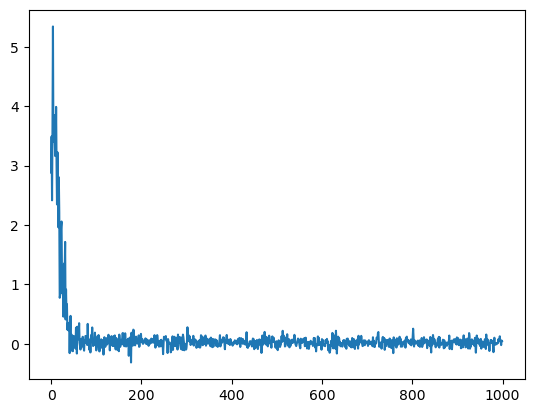

In [8]:
plt.plot(avs.losses)

In [9]:
torch.manual_seed(14)
res = avs.simulate(n_steps = 200, n_parallel = 4, initial_point = torch.tensor([-1.,-1.]), perturb=0.01)

print('rejection rate:', res['n_rejected']/200)

rejection rate: [0.045 0.075 0.075 0.07 ]


In [10]:
def convergence_detection_experiment(distribution, samplers, options, bounds=[(-5, 5), (-5, 5)]):
    D = options['initial_point'].shape[0]
    fig = plt.figure(constrained_layout=True, figsize=(20, 10))
    gs = fig.add_gridspec(2 * len(samplers), 1 + D)

    for i, sampler in enumerate(samplers):
#         result = simulate(distribution, proposal, **options)
        result = sampler.simulate(**options)
#         print(result['means'])
        ax = [fig.add_subplot(gs[2*i:2*i+2, 0])] + [fig.add_subplot(gs[2*i, 1+k]) for k in range(D)] + [fig.add_subplot(gs[2*i+1, 1+k]) for k in range(D)]
        plot_points(result['points'], ax[0])
        plot_statistics(result['points'], ax[1:1 + D])
        plot_traceplot(result['points'], ax[1 + D: 1 + 2 * D])

        ax[0].set_title(f'{sampler}, rejection rate = {result["rejection_rate"]:.2f}')
        ax[0].set_xlim(*bounds[0])
        ax[0].set_ylim(*bounds[1])
        ax[0].set_aspect('equal')

4


C:\Users\pcush\AppData\Local\Temp\ipykernel_18044\344778777.py:91: RuntimeWarning: invalid value encountered in sqrt
  e = np.sqrt(variances[i, :, j])


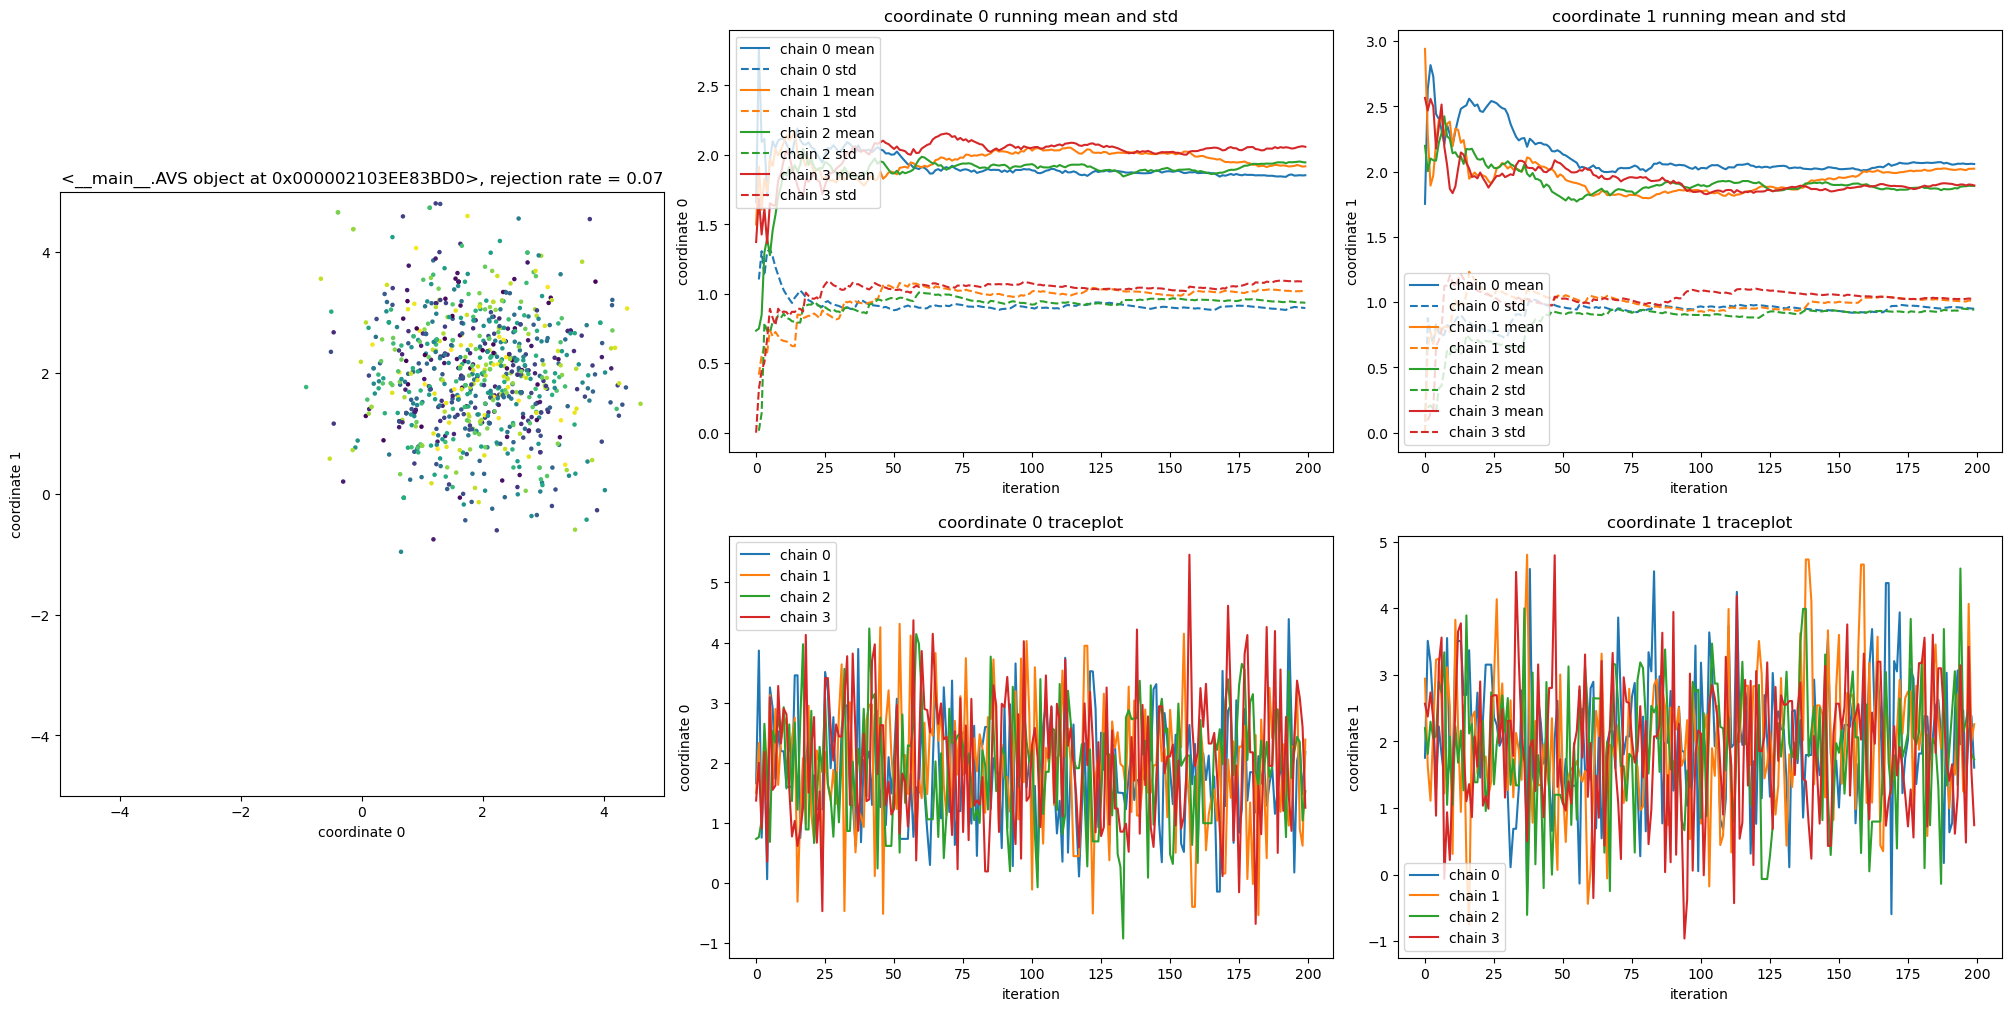

In [11]:
torch.manual_seed(14)
convergence_detection_experiment(
    normal,
    samplers =[avs],
    options = dict(n_steps = 200, 
                   n_parallel = 4, 
                   initial_point = torch.tensor([-1.,-1.]),
                   perturb=0.01
    )
);

# Testing

In [12]:
def autocorr_experiment_avs(distribution, samplers, steps, options):
    fig, axes = plt.subplots(nrows=len(steps), ncols=options['initial_point'].shape[0], figsize=(20, 10))

    for sampler in samplers:
        result = sampler.simulate(**options)
        xs = result['points']
        
        for i, step in enumerate(steps):
            plot_autocorr(xs, axes[i], step=step, mean=True, label=f'{sampler}')
    
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.5)
    return fig

In [71]:
def autocorr_experiment(distribution, proposals, steps, options):
    fig, axes = plt.subplots(nrows=len(steps), ncols=options['initial_point'].shape[0], figsize=(20, 10))

    for proposal in proposals:
        result = proposal.simulate(distribution, proposal, **options)
        xs = result['points']

        for i, step in enumerate(steps):
            plot_autocorr(xs, axes[i], step=step, mean=True, label=f'{proposal}')

    fig.tight_layout()
    fig.subplots_adjust(hspace=0.5)
    return fig

In [13]:
class Distribution:
    """Abstract class for unnormalized distribution"""
    
    def log_density(self, x):
        """
            Computes vectorized log of unnormalized log density
            
            x (torch tensor of shape BxD): B points at which we compute log density
            returns (torch tensor of shape B): \log \hat{\pi}(x) 
        """
        raise NotImplementedError
        
    def grad_log_density(self, x):
        """
            Computes vectorized gradient \nabla_x \log \pi(x)
            
            x (torch tensor of shape BxD): point at which we compute \nabla \log \pi
            returns (torch.tensor of shape BxD): gradients of log density
        """
        x = x.clone().requires_grad_()
        logp = self.log_density(x)
        logp.sum().backward()
        return x.grad

class Proposal:
    """Abstract class for proposal"""
    
    def sample(self, x):
        """
            Computes vectorized sample from proposal q(x' | x)
            
            x (torch tensor of shape BxD): current point from which we propose
            returns: (torch tensor of shape BxD) new points
        """
        raise NotImplementedError

    def log_density(self, x, x_prime):
        """
            Computes vectorized log of unnormalized log density
            
            x (torch tensor of shape BxD): B points at which we compute log density
            returns (torch tensor of shape B): \log q(x' | x) 
        """
        raise NotImplementedError
        
class MCMC:
    def __init__(self, distribution, proposal):
        """
            Constructs MCMC sampler
        
            distribution (Distribution): distribution from which we sample
            proposal (Proposal): MCMC proposal
        """
        self.distribution = distribution
        self.proposal = proposal
    
    def _step(self, x):
        x_prime = self.proposal.sample(x)
        acceptance_prob = self.acceptance_prob(x_prime, x)
        
        mask = torch.rand(x.shape[0]) < acceptance_prob
        x[mask] = x_prime[mask]
        self._rejected += (1 - 1*mask).type(torch.float32)
        return x

    def simulate(self, initial_point, n_steps, n_parallel=10):
        """
            Run `n_parallel ` simulations for `n_steps` starting from `initial_point`
            
            initial_point (torch tensor of shape D): starting point for all chains
            n_steps (int): number of samples in Markov chain
            n_parallel (int): number of parallel chains
            returns: dict(
                points (torch tensor of shape n_parallel x n_steps x D): samples
                n_rejected (numpy array of shape n_parallel): number of rejections for each chain
                rejection_rate (float): mean rejection rate over all chains
                means (torch tensor of shape n_parallel x n_steps x D): means[c, s] = mean(points[c, :s])
                variances (torch tensor of shape n_parallel x n_steps x D): variances[c, s, d] = variance(points[c, :s, d])
            )
        """
        xs = []
        x = initial_point.repeat(n_parallel, 1)
        self._rejected = torch.zeros(n_parallel)
        
        dim = initial_point.shape[0]
        sums = np.zeros([n_parallel, dim])
        squares_sum = np.zeros([n_parallel, dim])
        
        means = []
        variances = []        
        
        for i in range(n_steps):
            x = self._step(x)
            xs.append(x.numpy().copy())
            
            sums += xs[-1]
            squares_sum += xs[-1]**2
            
            mean, squares_mean = sums / (i + 1), squares_sum / (i + 1)
            means.append(mean.copy())
            variances.append(squares_mean - mean**2)
        
        xs = np.stack(xs, axis=1)        
        means = np.stack(means, axis=1)
        variances = np.stack(variances, axis=1)
        
        return dict(
            points=xs,
            n_rejected=self._rejected.numpy(),
            rejection_rate=(self._rejected / n_steps).mean().item(),
            means=means,
            variances=variances
        )
        
    def acceptance_prob(self, x_prime, x):
        """
            In this function you need to compute 
            probability of acceptance \rho(x' | x)

            x_prime (numpy array): new point
            x (numpy array): current point
            returns: acceptance probability \rho(x', x)
        """
    
        # TODO
        pi_new = self.distribution.log_density(x_prime)
        pi_old = self.distribution.log_density(x)
        q_new = self.proposal.log_density(x_prime, x)
        q_old = self.proposal.log_density(x, x_prime)
        ratio = torch.exp(pi_new - pi_old + q_new - q_old)
        return ratio.clamp(0., 1.)
    
def simulate(distribution, proposal, initial_point, n_samples, n_parallel=10):
    mcmc = MCMC(distribution, proposal)
    return mcmc.simulate(initial_point, n_samples, n_parallel)

In [14]:
class Normal(Distribution):
    """Represents normal distribution N(mean, std)"""
    
    def __init__(self, loc, scale):
        """
            loc (torch tensor of shape D): mean
            scale (torch tensor of shape D) std
        """
        self.dist = dist.Normal(loc=loc, scale=scale)

    def log_density(self, x):
        return self.dist.log_prob(x).sum(dim=-1)


class MixtureOfNormals(Distribution):
    """Represents mixture of normals: \pi(x) = \sum_k \pi_k N(x | mean_k, std_k)"""
    def __init__(self, locs, scales, pi):
        """
            locs (torch tensor of shape NxD): locs[k] = mean_k
            scales (torch tensor of shape NxD): scales[k] = std_k
            pi (torch.tensor of shape N): pi[k] = pi_k
        """
        self.dists = [
            dist.Normal(loc=loc, scale=scale)
            for loc, scale in zip(locs, scales)
        ]
        self.pi = pi
        
    def log_density(self, x):
        log_densities = torch.stack([
            d.log_prob(x).sum(dim=-1)
            for d in self.dists
        ], dim=0)
        return torch.logsumexp(torch.log(self.pi).view(-1, 1) + log_densities, dim=0)
       

    
class LangevinMixture(Distribution):
    """
        This distribution is defined as posterior on theta_1, theta_2 given
        prior: theta_1 ~ N(0, \sigma_1^2), theta_2 ~ N(0, \sigma_2^2)
        likelihood: x_i ~ 0.5 * N(theta_1, \sigma_x^2) + 0.5 * N(theta_1 + theta_2, \sigma_x^2)
        
        More detailed information can be found at 
        https://www.ics.uci.edu/~welling/publications/papers/stoclangevin_v6.pdf
    """
    
    def __init__(self, theta1=0., theta2=1., 
                       s1=np.sqrt(10.), s2=1., sx=np.sqrt(2.), N=100):
        mu = torch.tensor([theta1, theta1 + theta2])
        pi = np.random.binomial(n=1, p=0.5, size=N).astype(np.int64)

        d = dist.Normal(loc=mu, scale=sx)
        self.X = d.sample((N,))[np.arange(N), pi]
    
        self.d1 = dist.Normal(loc=0., scale=s1)
        self.d2 = dist.Normal(loc=0., scale=s2)
        self.dx = dist.Normal(loc=0., scale=sx)
    
    def log_density(self, theta):
        theta1, theta2 = theta[..., 0], theta[..., 1]
        log_prior = self.d1.log_prob(theta1) + self.d2.log_prob(theta2)
        
        mu = torch.stack([theta1, theta1 + theta2], dim=-1)
        
        log_likelihood = self.dx.log_prob(self.X[None, :, None] - mu[:, None])
        log_likelihood = torch.logsumexp(log_likelihood, dim=-1)
        return log_prior + log_likelihood.sum(dim=-1)
    


In [15]:
standard_normal = Normal(loc=0., scale=1.)
scaled_normal = Normal(loc=0., scale=torch.tensor([10., 1.]))
mixture = MixtureOfNormals(
    locs=[torch.tensor([3., -2.]), torch.tensor([5., 5.])], 
    scales=[1., 1.],
    pi=torch.tensor([0.5, 0.5])
)

langevin = LangevinMixture()

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
plot_distribution(standard_normal, bounds=((-3, 3), (-3, 3)), ax=axes[0][0], num=100, n_levels=20)
plot_distribution_grad(standard_normal, bounds=((-3, 3), (-3, 3)), ax=axes[0][0], num=20)
axes[0][0].set_title('standard normal')

plot_distribution(scaled_normal, bounds=((-100, 100), (-100, 100)), ax=axes[0][1], num=100, n_levels=20)
plot_distribution_grad(scaled_normal, bounds=((-100, 100), (-100, 100)), ax=axes[0][1], num=20)
axes[0][1].set_title('scaled normal')

plot_distribution(mixture, bounds=((-4, 8), (-4, 8)), ax=axes[1][0], num=100, n_levels=20)
plot_distribution_grad(mixture, bounds=((-4, 8), (-4, 8)), ax=axes[1][0], num=20)
axes[1][0].set_title('mixture of normals')

plot_distribution(langevin, bounds=((-3, 3), (-3, 3)), ax=axes[1][1], num=100, n_levels=20)
plot_distribution_grad(langevin, bounds=((-3, 3), (-3, 3)), ax=axes[1][1], num=20)
axes[1][1].set_title('langevin mixture');

  0%|          | 0/1000 [00:00<?, ?it/s]

3


C:\Users\pcush\AppData\Local\Temp\ipykernel_18044\344778777.py:91: RuntimeWarning: invalid value encountered in sqrt
  e = np.sqrt(variances[i, :, j])


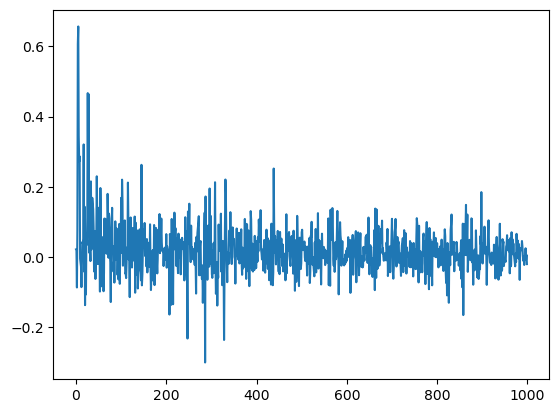

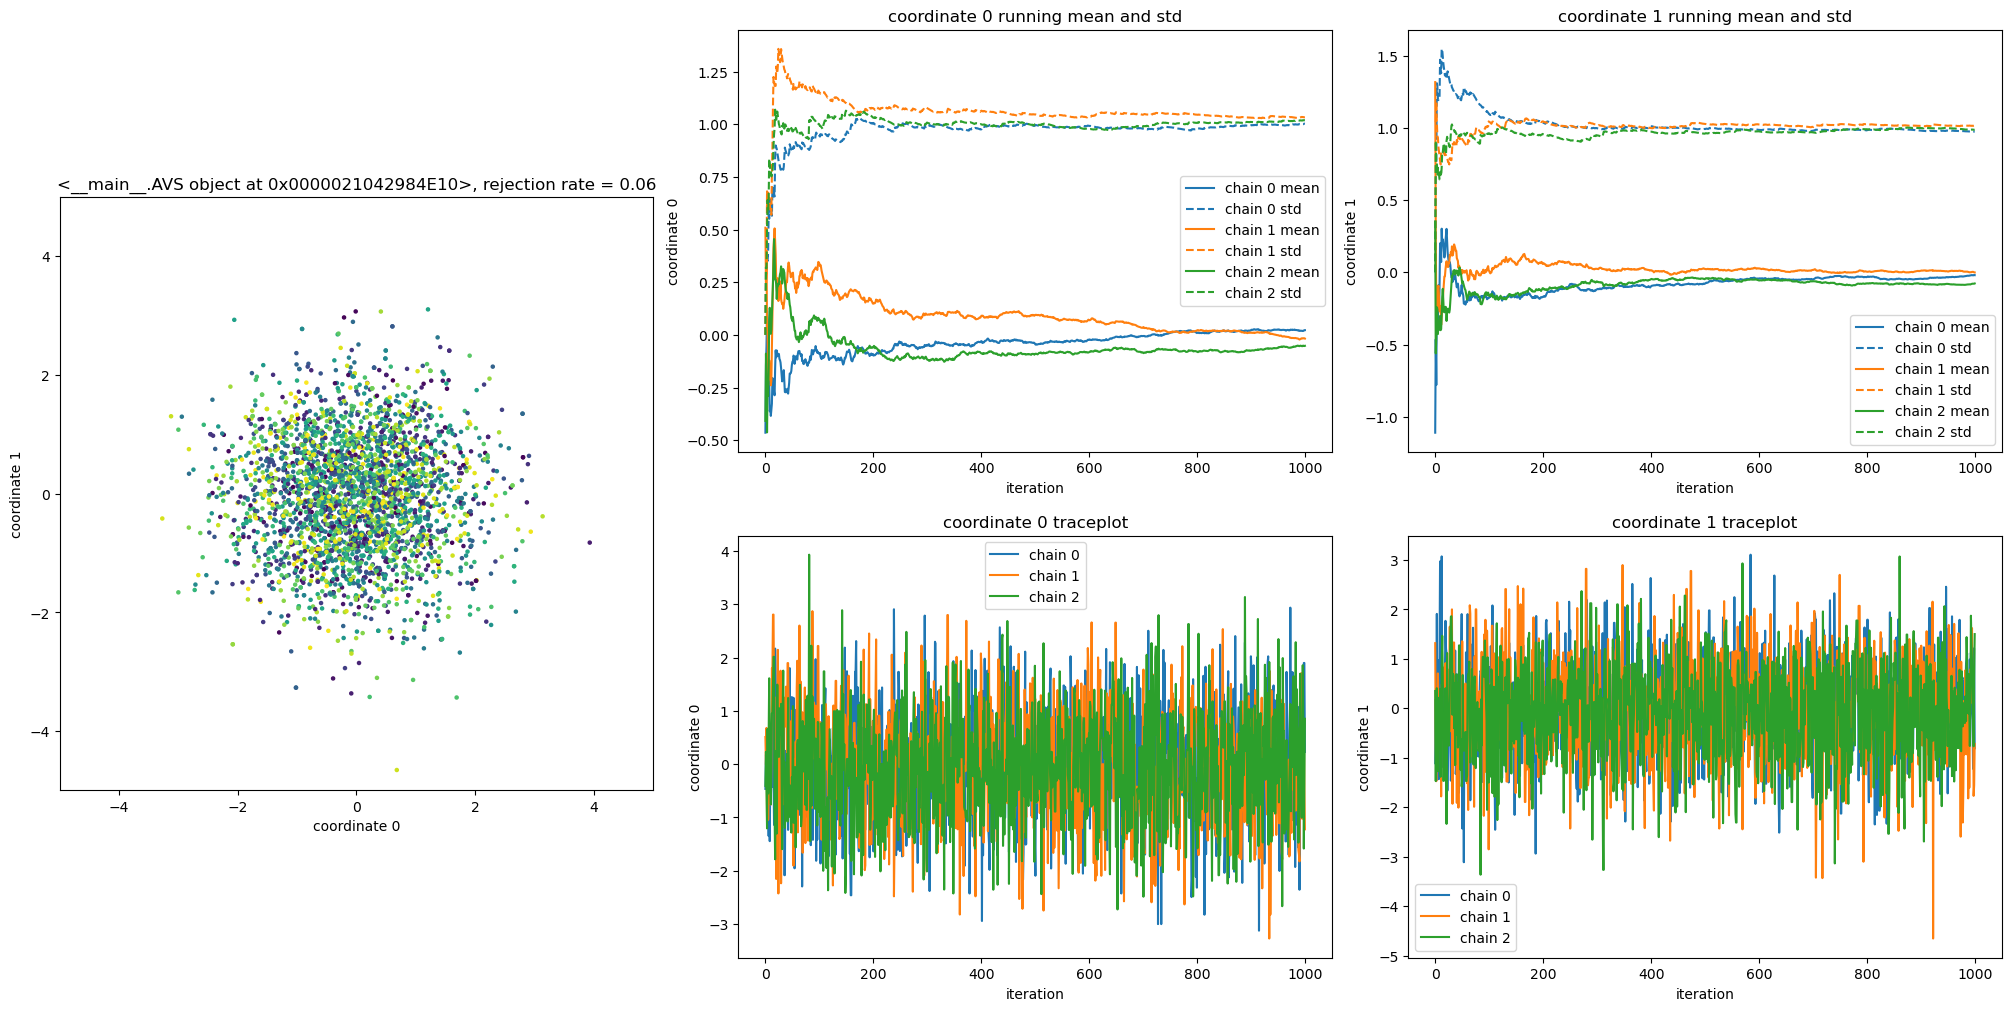

In [16]:
torch.manual_seed(14)
curr_dist = standard_normal
energy_func = curr_dist.log_density
avs =AVS(energy_func=energy_func, 
    target_dim=2, 
    aux_dim=2)

avs.train(max_iters = 1000,     learning_rate=1e-3)
plt.plot(avs.losses)

convergence_detection_experiment(
    curr_dist,
    samplers =[avs],
    options = dict(n_steps = 1000, 
                   n_parallel = 3, 
                   initial_point = torch.tensor([-.1, -.1]),
                   perturb=0.01
    )
);

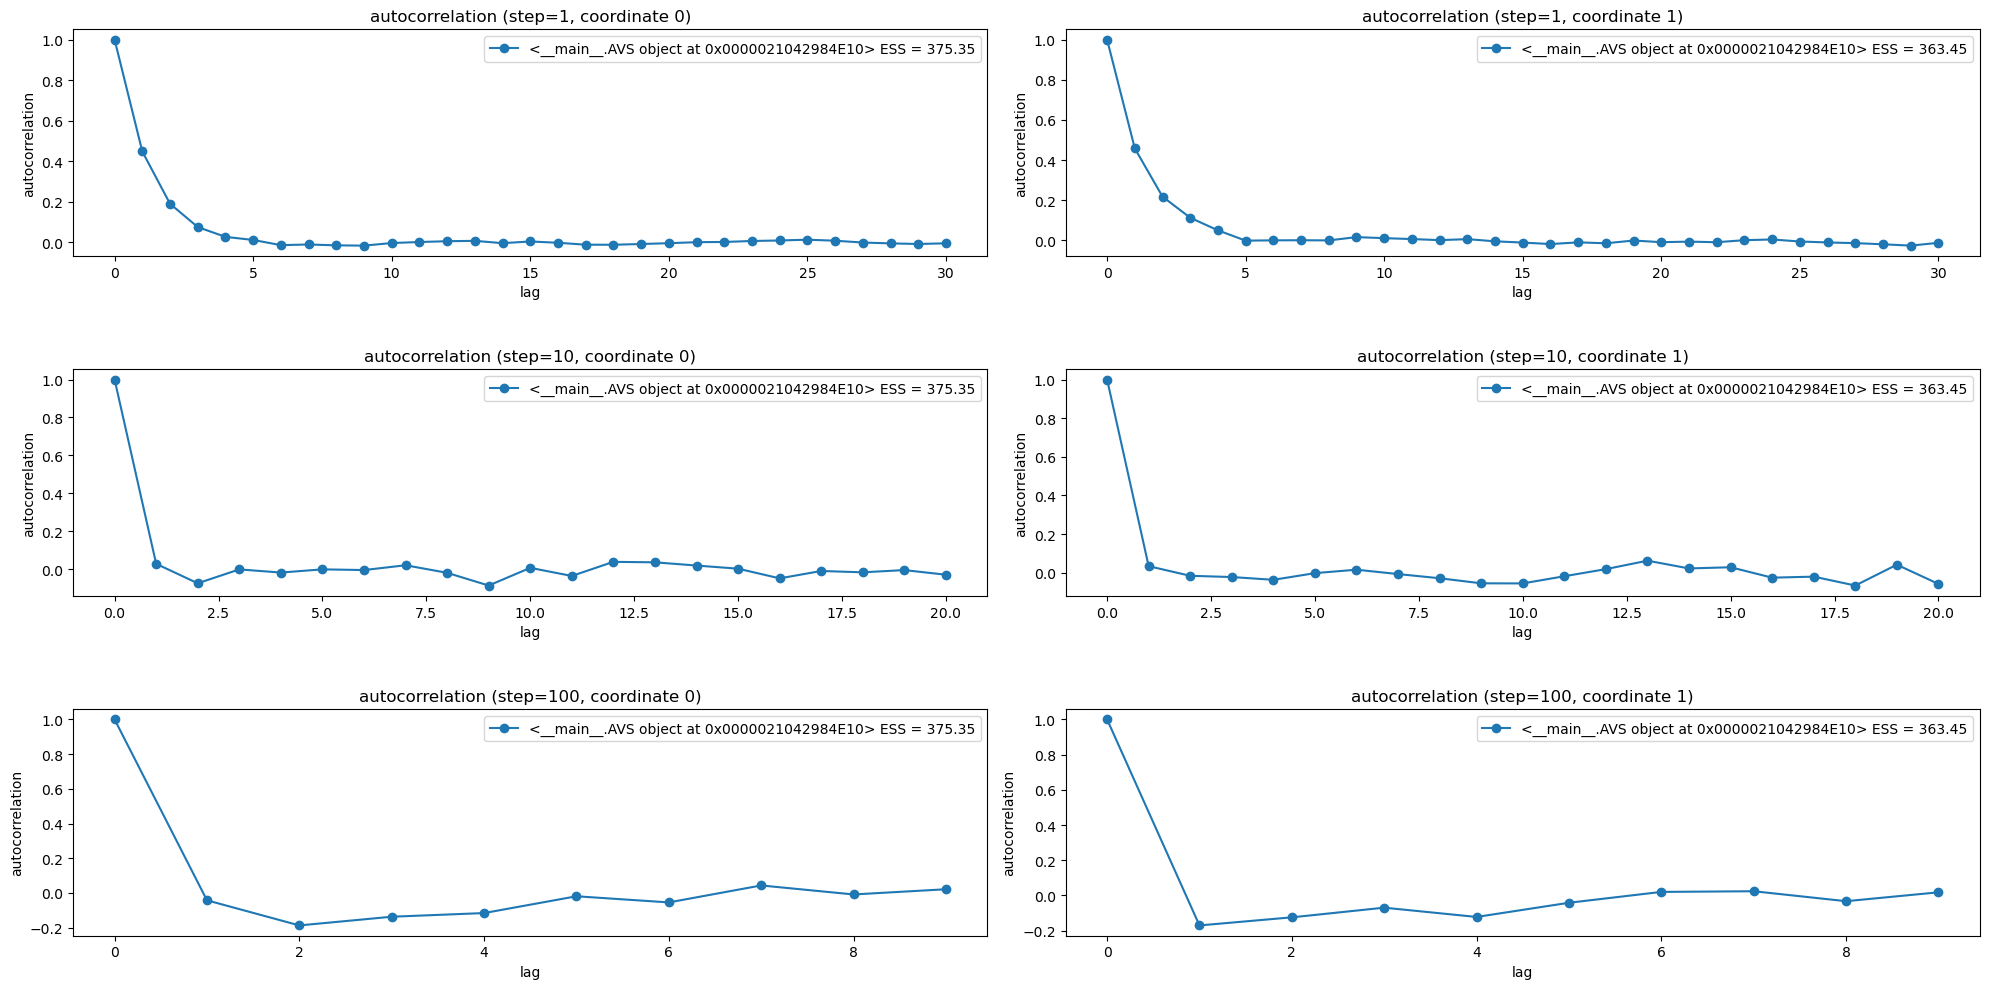

In [17]:
torch.manual_seed(14)
autocorr_experiment_avs(
    distribution=curr_dist,
    samplers=[avs],
    steps=[1, 10, 100],
    options = dict(
        initial_point=torch.tensor([0., 0.]),
        n_steps=1000,
        n_parallel=10
    )
);

In [18]:
torch.manual_seed(14)
curr_dist = scaled_normal
energy_func = curr_dist.log_density
avs =AVS(energy_func=energy_func, 
    target_dim=2, 
    aux_dim=2)

avs.train(max_iters = 1000,     learning_rate=1e-3)
plt.plot(avs.losses)

convergence_detection_experiment(
    curr_dist,
    samplers =[avs],
    options = dict(n_steps = 1000, 
                   n_parallel = 3, 
                   initial_point = torch.tensor([-.1, -.1]),
                   perturb=0.01
    )
);

  0%|          | 0/1000 [00:00<?, ?it/s]

3


C:\Users\pcush\AppData\Local\Temp\ipykernel_18044\344778777.py:91: RuntimeWarning: invalid value encountered in sqrt
  e = np.sqrt(variances[i, :, j])


In [19]:
torch.manual_seed(14)
autocorr_experiment_avs(
    distribution=curr_dist,
    samplers=[avs],
    steps=[1, 10, 100],
    options = dict(
        initial_point=torch.tensor([0., 0.]),
        n_steps=1000,
        n_parallel=10
    )
);

  0%|          | 0/1000 [00:00<?, ?it/s]

3


C:\Users\pcush\AppData\Local\Temp\ipykernel_18044\344778777.py:91: RuntimeWarning: invalid value encountered in sqrt
  e = np.sqrt(variances[i, :, j])


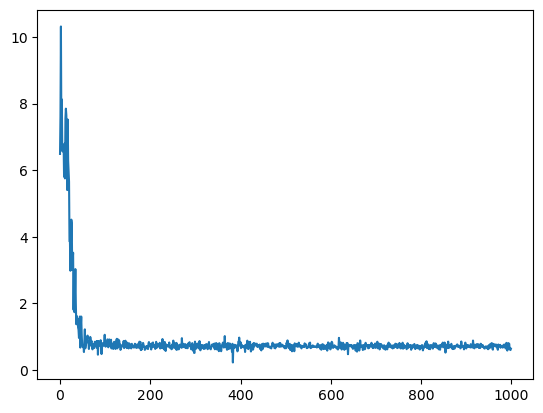

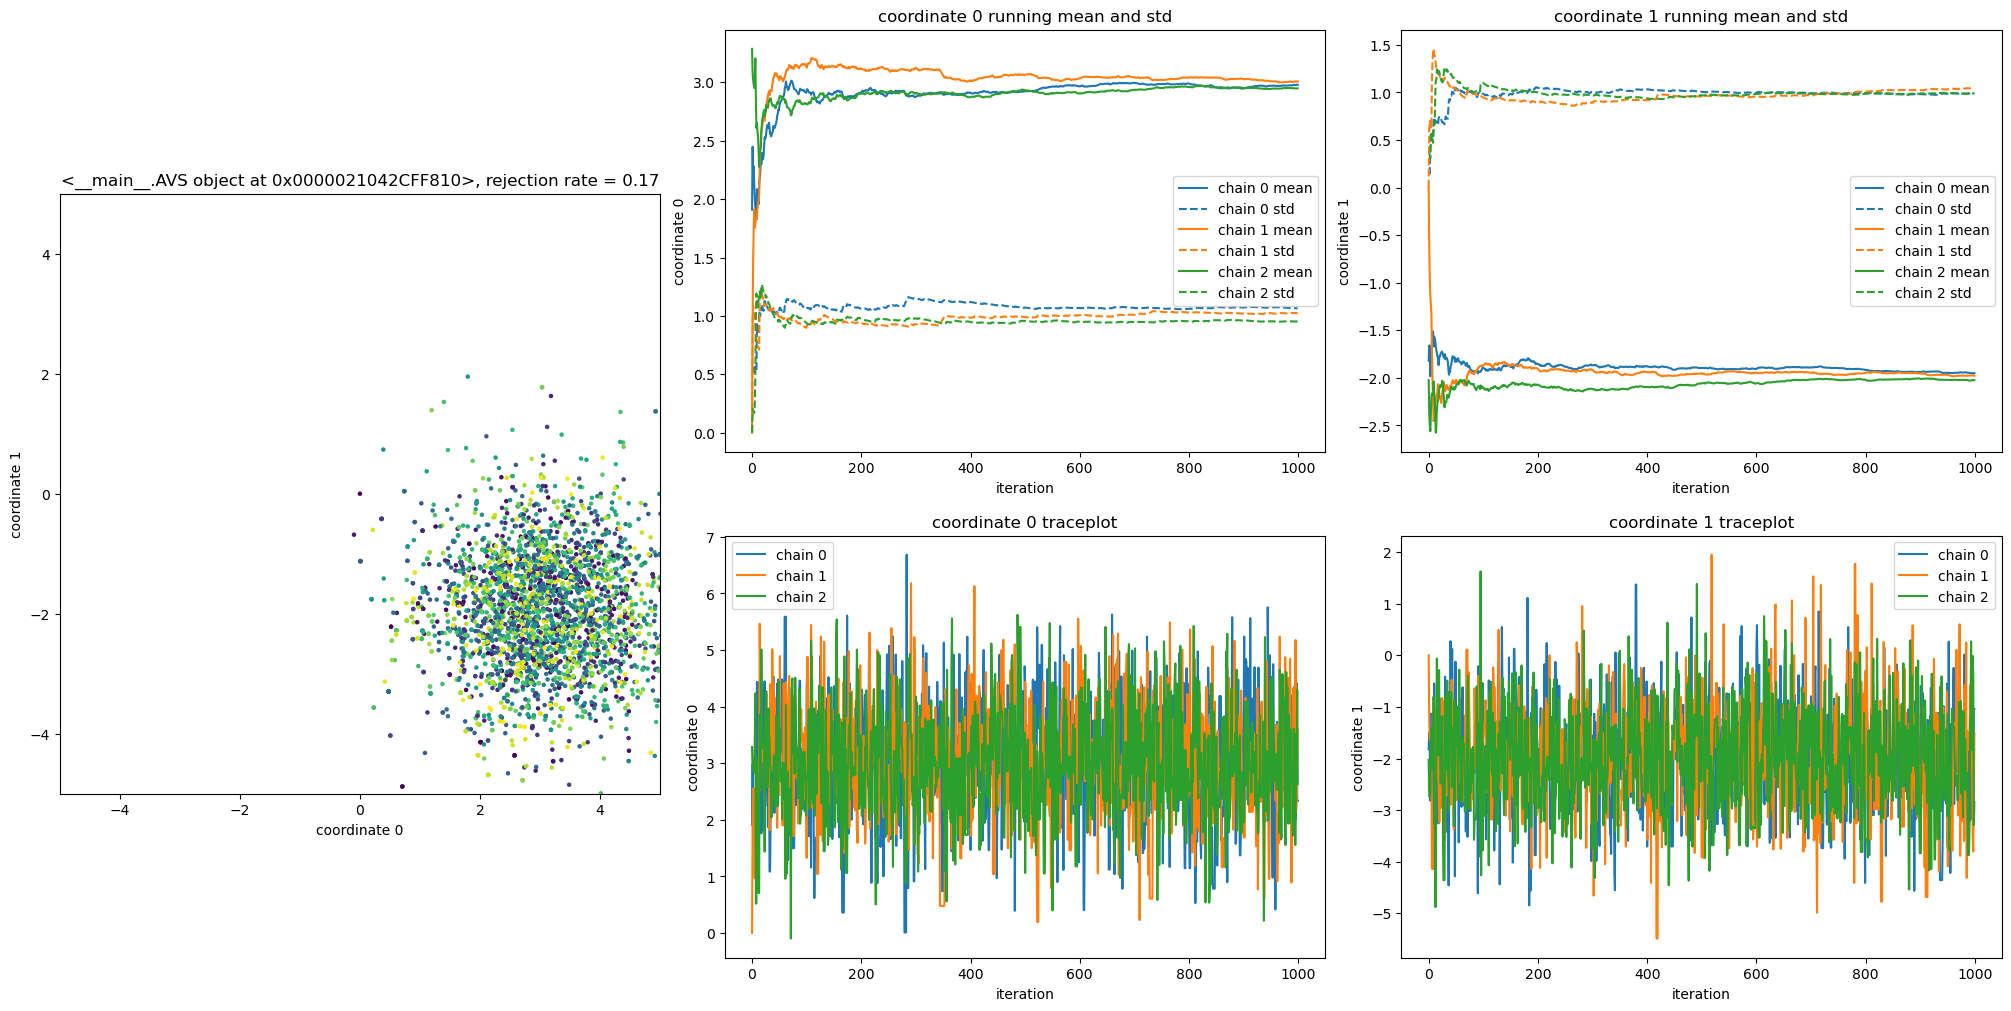

In [20]:
torch.manual_seed(14)
curr_dist = mixture
energy_func = curr_dist.log_density
avs =AVS(energy_func=energy_func, 
    target_dim=2, 
    aux_dim=2)

avs.train(max_iters = 1000,     learning_rate=1e-4)
plt.plot(avs.losses)

convergence_detection_experiment(
    curr_dist,
    samplers =[avs],
    options = dict(n_steps = 1000, 
                   n_parallel = 3, 
                   initial_point = torch.tensor([0., 0.]),
                   perturb=0.01
    )
);

In [21]:
#ходит по одной ближайшей компоненте почему-то

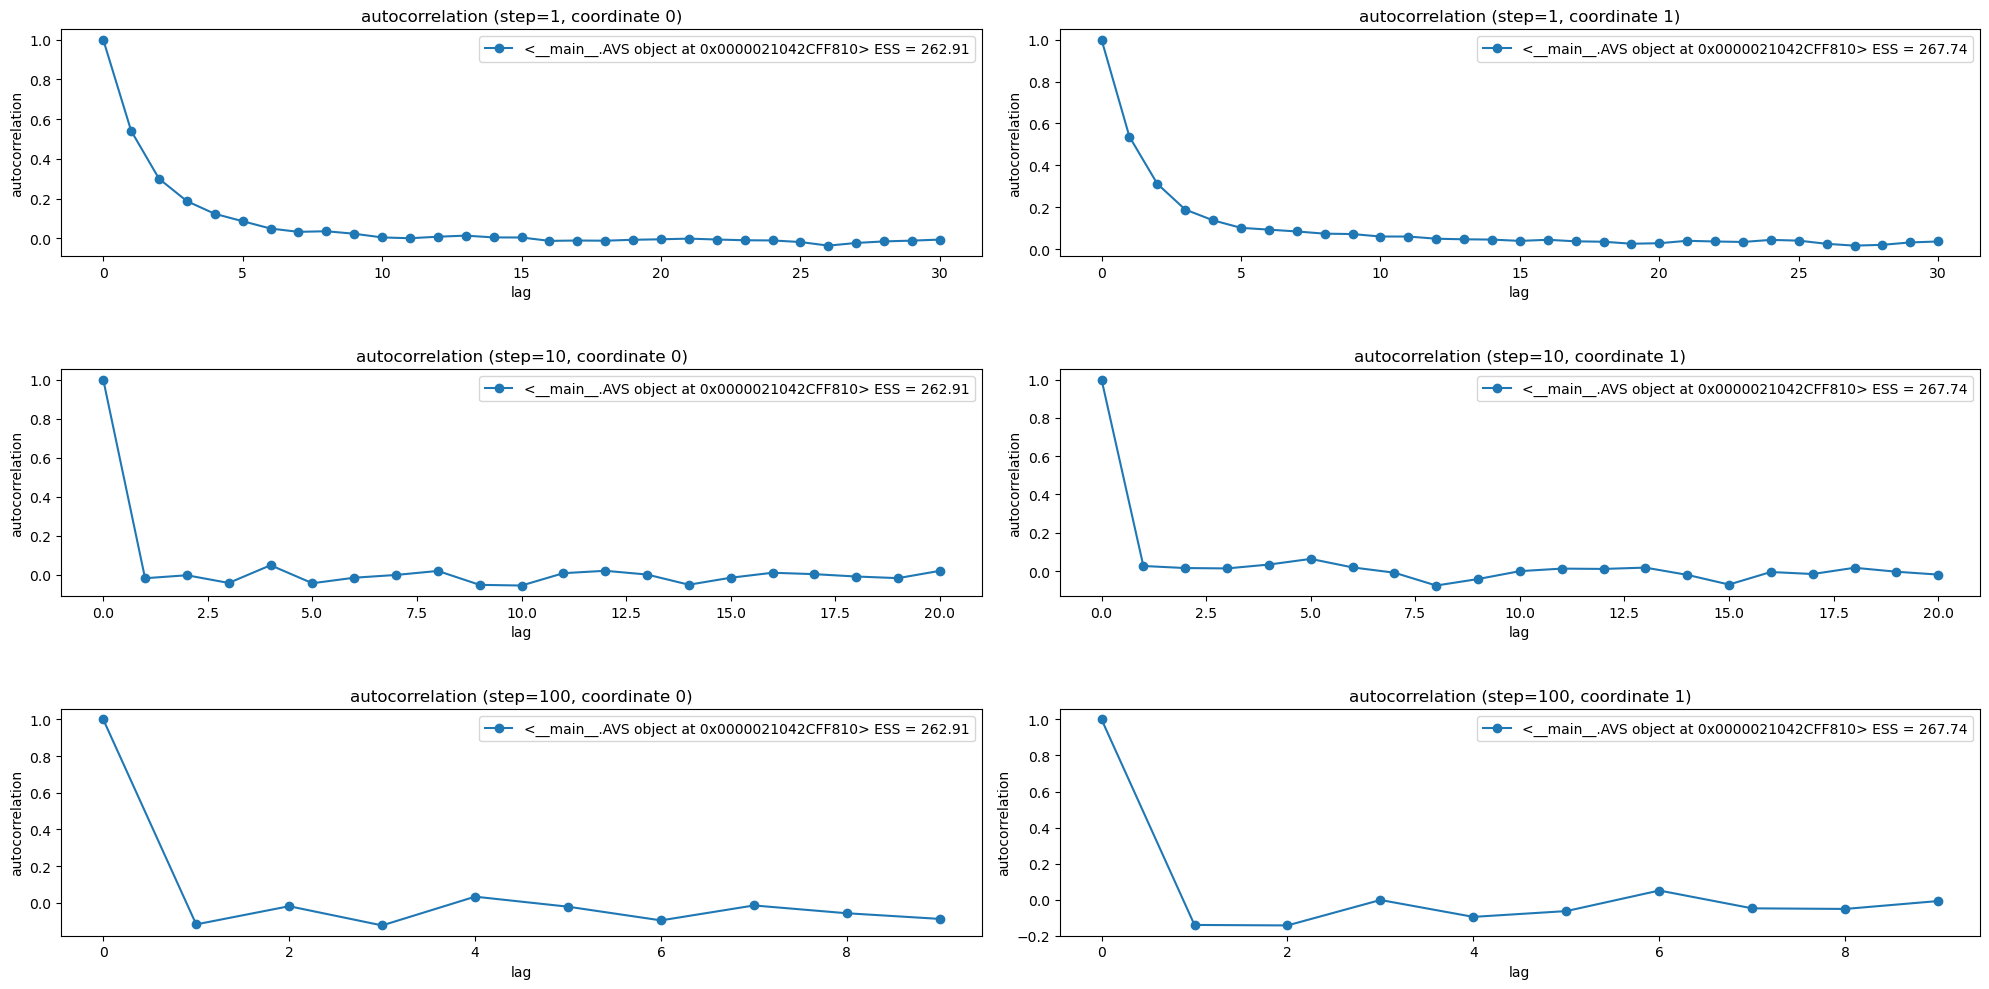

In [22]:
torch.manual_seed(14)
autocorr_experiment_avs(
    distribution=curr_dist,
    samplers=[avs],
    steps=[1, 10, 100],
    options = dict(
        initial_point=torch.tensor([0., 0.]),
        n_steps=1000,
        n_parallel=10
    )
);

  0%|          | 0/1000 [00:00<?, ?it/s]

3


C:\Users\pcush\AppData\Local\Temp\ipykernel_18044\344778777.py:91: RuntimeWarning: invalid value encountered in sqrt
  e = np.sqrt(variances[i, :, j])


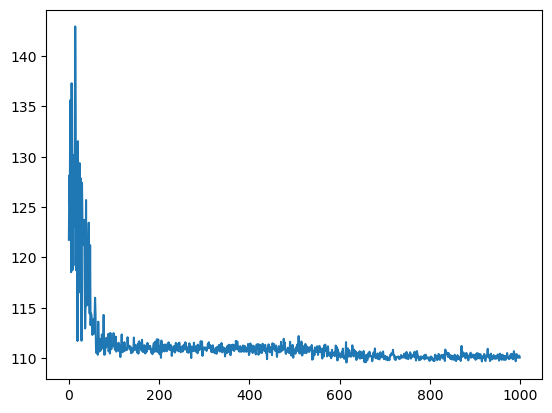

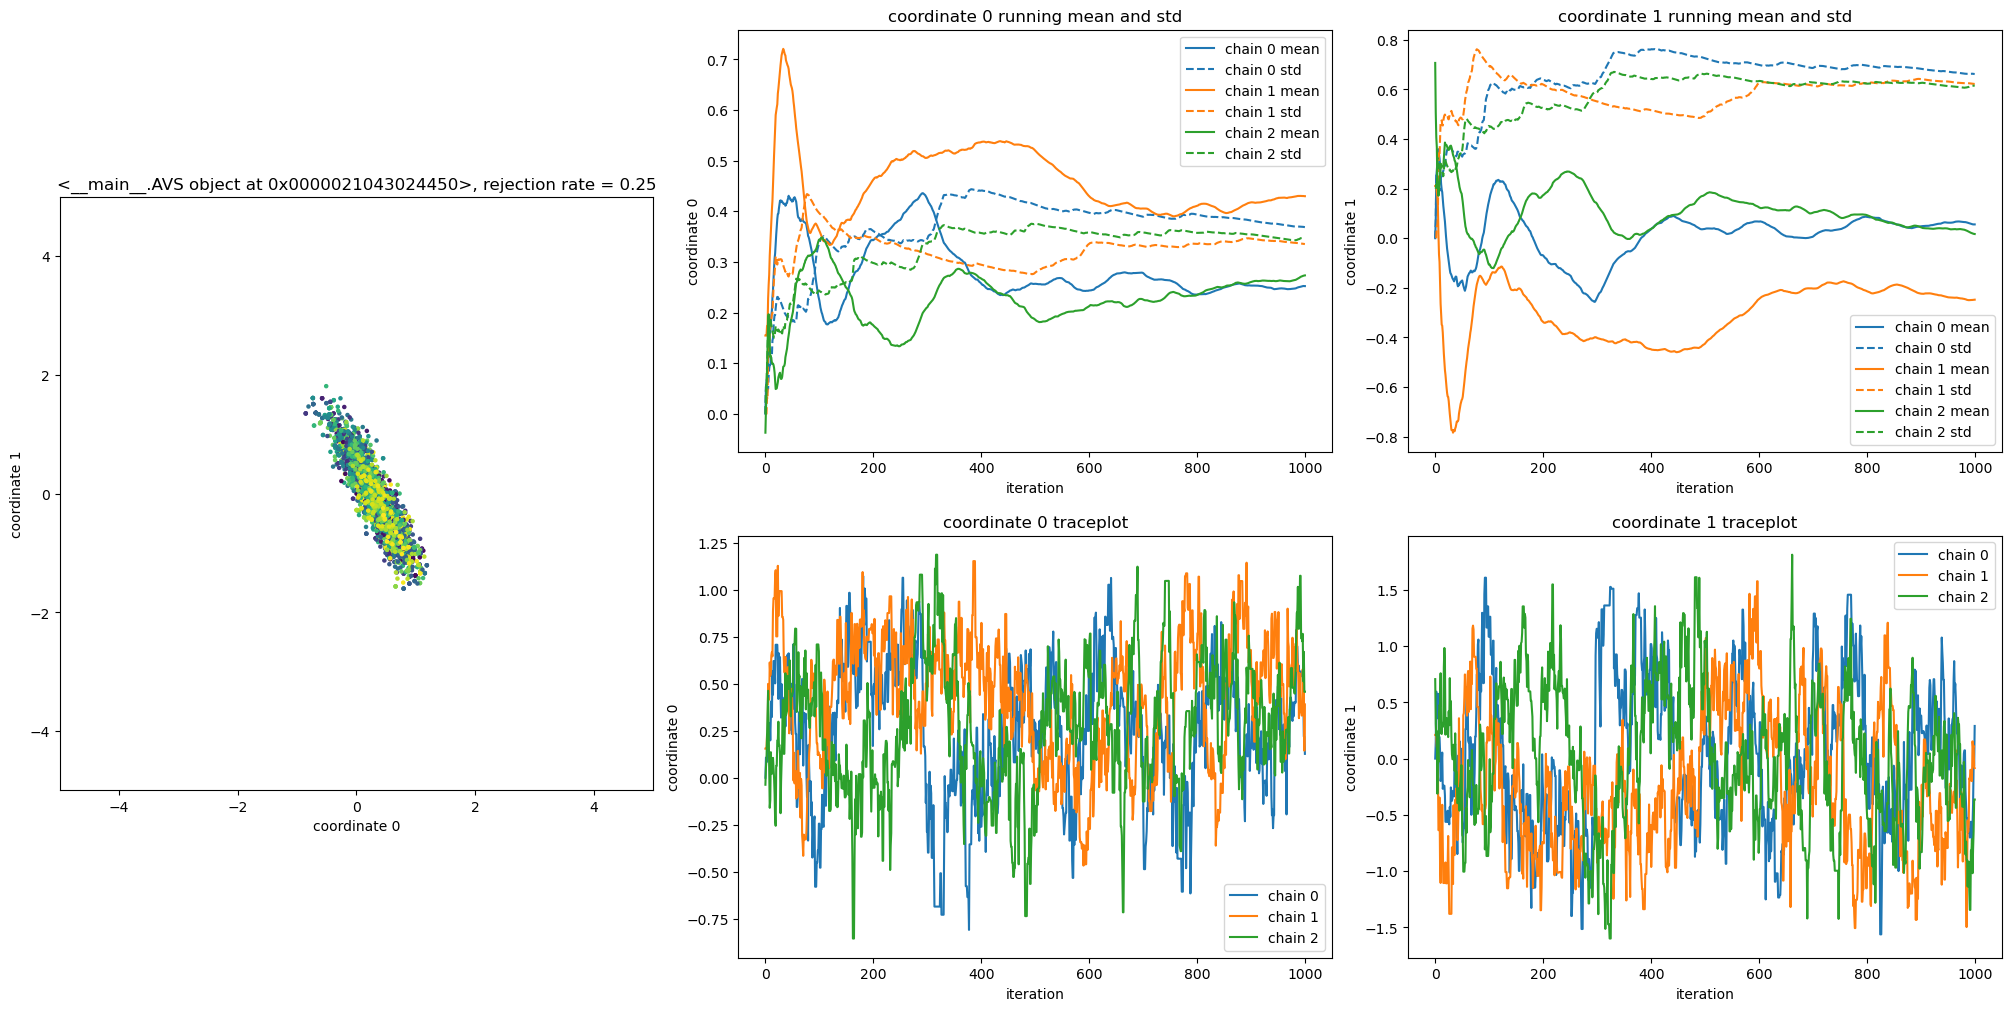

In [23]:
torch.manual_seed(14)
curr_dist = langevin 
energy_func = curr_dist.log_density
avs =AVS(energy_func=energy_func, 
    target_dim=2, 
    aux_dim=2)

avs.train(max_iters = 1000,     learning_rate=1e-4)
plt.plot(avs.losses)

convergence_detection_experiment(
    curr_dist,
    samplers =[avs],
    options = dict(n_steps = 1000, 
                   n_parallel = 3, 
                   initial_point = torch.tensor([0., 0.]),
                   perturb=0.01
    )
);

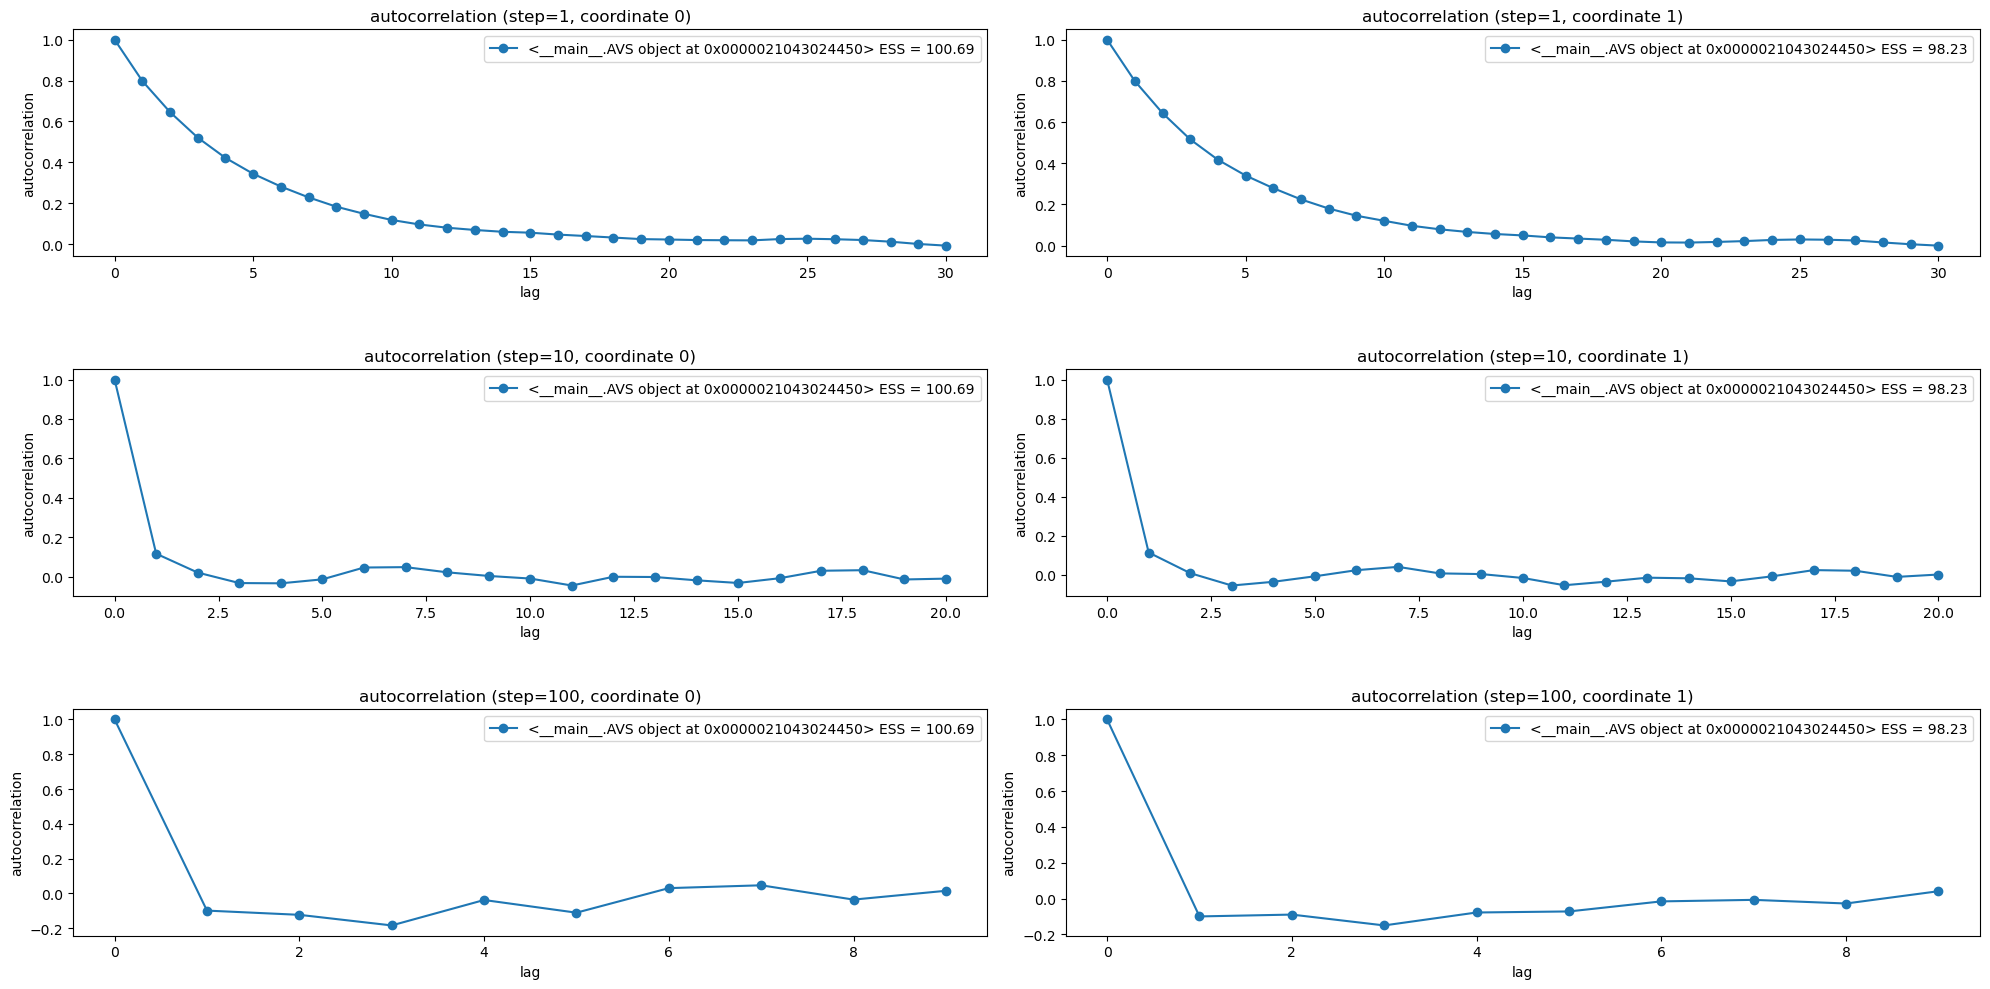

In [24]:
torch.manual_seed(14)
autocorr_experiment_avs(
    distribution=curr_dist,
    samplers=[avs],
    steps=[1, 10, 100],
    options = dict(
        initial_point=torch.tensor([0., 0.]),
        n_steps=1000,
        n_parallel=10
    )
);

In [25]:
class Funnel(Distribution):
    def __init__(self):
        self.d = dist.Normal(loc=0., scale=np.sqrt(3.))

    def log_density(self, y):
        x, z = y[:, 0], y[:, 1]
        logp_z = self.d.log_prob(z).sum(dim=-1)
        logp_x = dist.Normal(loc=0., scale=z.mul(0.25).exp()).log_prob(x)
        return logp_z + logp_x

In [26]:
funnel = Funnel()

In [46]:
torch.manual_seed(14)
curr_dist = funnel
energy_func = curr_dist.log_density
avs =AVS(energy_func=energy_func, 
    target_dim=2, 
    aux_dim=2)

avs.train(max_iters = 1000,     learning_rate=1e-4)
plt.plot(avs.losses)

convergence_detection_experiment(
    curr_dist,
    samplers =[avs],
    options = dict(n_steps = 1000, 
                   n_parallel = 3, 
                   initial_point = torch.tensor([0., 0.]),
                   perturb=0.01
    )
);

  0%|          | 0/1000 [00:00<?, ?it/s]

3


C:\Users\pcush\AppData\Local\Temp\ipykernel_18044\344778777.py:91: RuntimeWarning: invalid value encountered in sqrt
  e = np.sqrt(variances[i, :, j])


In [47]:
torch.manual_seed(14)
autocorr_experiment_avs(
    distribution=curr_dist,
    samplers=[avs],
    steps=[1, 10, 100],
    options = dict(
        initial_point=torch.tensor([0., 0.]),
        n_steps=1000,
        n_parallel=10
    )
);

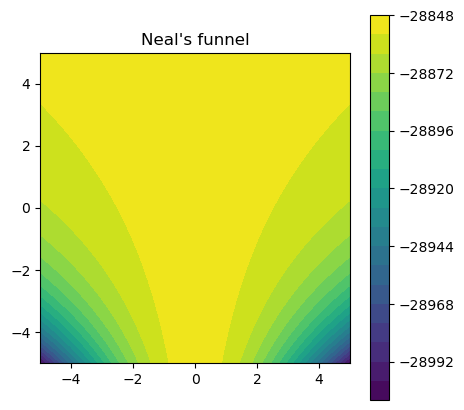

In [29]:
fig, axes = plt.subplots(ncols=1, figsize=(5, 5))
r = plot_distribution(curr_dist, bounds=((-5, 5), (-5, 5)), ax=axes, num=100, n_levels=20, filled=True)[1]
axes.set_title("Neal's funnel")
axes.set_aspect('equal')
fig.colorbar(r, ax=axes)

In [54]:
class Banan(Distribution):
    def __init__(self):
        self.x2 = dist.Normal(loc=0. , scale = 1)

    def log_density(self, y):
        y2, y1 = y[:, 0], y[:, 1]
        logp_x2 = self.x2.log_prob(y1).sum(dim=-1)
        logp_x1 = dist.Normal(loc = 2 * (y2 ** 2 - 5), scale = 1).log_prob(y1)
        return logp_x1 + logp_x2

In [55]:
banan = Banan()

In [62]:
torch.manual_seed(14)
curr_dist = banan
energy_func = curr_dist.log_density
avs =AVS(energy_func=energy_func, 
    target_dim=2, 
    aux_dim=2)

avs.train(max_iters = 1000,     learning_rate=1e-4)
plt.plot(avs.losses)

convergence_detection_experiment(
    curr_dist,
    samplers =[avs],
    options = dict(n_steps = 1000, 
                   n_parallel = 3, 
                   initial_point = torch.tensor([0., 0.]),
                   perturb=0.01
    )
);

  0%|          | 0/1000 [00:00<?, ?it/s]

3


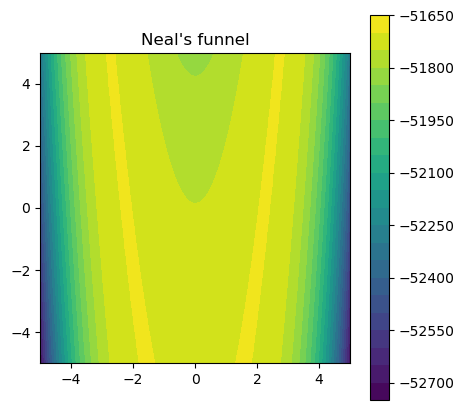

In [61]:
fig, axes = plt.subplots(ncols=1, figsize=(5, 5))
r = plot_distribution(curr_dist, bounds=((-5, 5), (-5, 5)), ax=axes, num=100, n_levels=20, filled=True)[1]
axes.set_title("Banana")
axes.set_aspect('equal')
fig.colorbar(r, ax=axes)

# Comparison with Langevin and Metropolis

In [64]:
class Langevin_din:
    def __init__(self, distribution, proposal):
        """
            Constructs MCMC sampler

            distribution (Distribution): distribution from which we sample
            proposal (Proposal): MCMC proposal
        """
        self.distribution = distribution
        self.proposal = proposal

    def _step(self, x):
        x_prime = self.proposal.sample(x)
        #acceptance_prob = self.acceptance_prob(x_prime, x)

        mask = torch.rand(x.shape[0]) <=torch.ones(x_prime.shape[0])
        x[mask] = x_prime[mask]
        self._rejected += (~mask).type(torch.float32)
        return x

    def simulate(self, initial_point, n_steps, n_parallel=10):
        """
            Run `n_parallel ` simulations for `n_steps` starting from `initial_point`

            initial_point (torch tensor of shape D): starting point for all chains
            n_steps (int): number of samples in Markov chain
            n_parallel (int): number of parallel chains
            returns: dict(
                points (torch tensor of shape n_parallel x n_steps x D): samples
                n_rejected (numpy array of shape n_parallel): number of rejections for each chain
                rejection_rate (float): mean rejection rate over all chains
                means (torch tensor of shape n_parallel x n_steps x D): means[c, s] = mean(points[c, :s])
                variances (torch tensor of shape n_parallel x n_steps x D): variances[c, s, d] = variance(points[c, :s, d])
            )
        """
        xs = []
        x = initial_point.repeat(n_parallel, 1)
        self._rejected = torch.zeros(n_parallel)

        dim = initial_point.shape[0]
        sums = np.zeros([n_parallel, dim])
        squares_sum = np.zeros([n_parallel, dim])

        means = []
        variances = []

        for i in range(n_steps):
            x = self._step(x)
            xs.append(x.numpy().copy())

            sums += xs[-1]
            squares_sum += xs[-1]**2

            mean, squares_mean = sums / (i + 1), squares_sum / (i + 1)
            means.append(mean.copy())
            variances.append(squares_mean - mean**2)

        xs = np.stack(xs, axis=1)
        means = np.stack(means, axis=1)
        variances = np.stack(variances, axis=1)

        return dict(
            points=xs,
            n_rejected=self._rejected.numpy(),
            rejection_rate=(self._rejected / n_steps).mean().item(),
            means=means,
            variances=variances
        )

def simulate_lanj(distribution, proposal, initial_point, n_samples, n_parallel=10):
    lanj = Langevin_din(distribution, proposal)
    return lanj.simulate(initial_point, n_samples, n_parallel)

In [65]:
def autocorr_experiment_lanj(distribution, proposals, steps, options):
    fig, axes = plt.subplots(nrows=len(steps), ncols=options['initial_point'].shape[0], figsize=(20, 10))

    for proposal in proposals:
        result = simulate_lanj(distribution, proposal, **options)
        xs = result['points']

        for i, step in enumerate(steps):
            plot_autocorr(xs, axes[i], step=step, mean=True, label=f'{proposal}')

    fig.tight_layout()
    fig.subplots_adjust(hspace=0.5)
    return fig

In [66]:
class Langevin(Proposal):
    """Proposal given by q(x' | x) = N(x' | x - 0.5 * eps * \nabla \log \pi(x), eps)"""
    def __init__(self, eps, d):
        self.d = dist.Normal(loc=0., scale=np.sqrt(eps))
        self.dist = d
        self.eps = eps

    def sample(self, x):
        return x - 0.5 * self.eps * self.dist.grad_log_density(x) + self.d.sample(sample_shape=x.shape)

    def log_density(self, x, x_prime):
        xn = x - 0.5 * self.eps * self.dist.grad_log_density(x)
        return self.d.log_prob(x_prime - xn).sum(dim=-1)

    def __str__(self):
        return f"Langevin eps={self.eps}"

### Langevin

C:\Users\pcush\AppData\Local\Temp\ipykernel_18044\4025336792.py:52: RuntimeWarning: overflow encountered in square
  squares_sum += xs[-1]**2


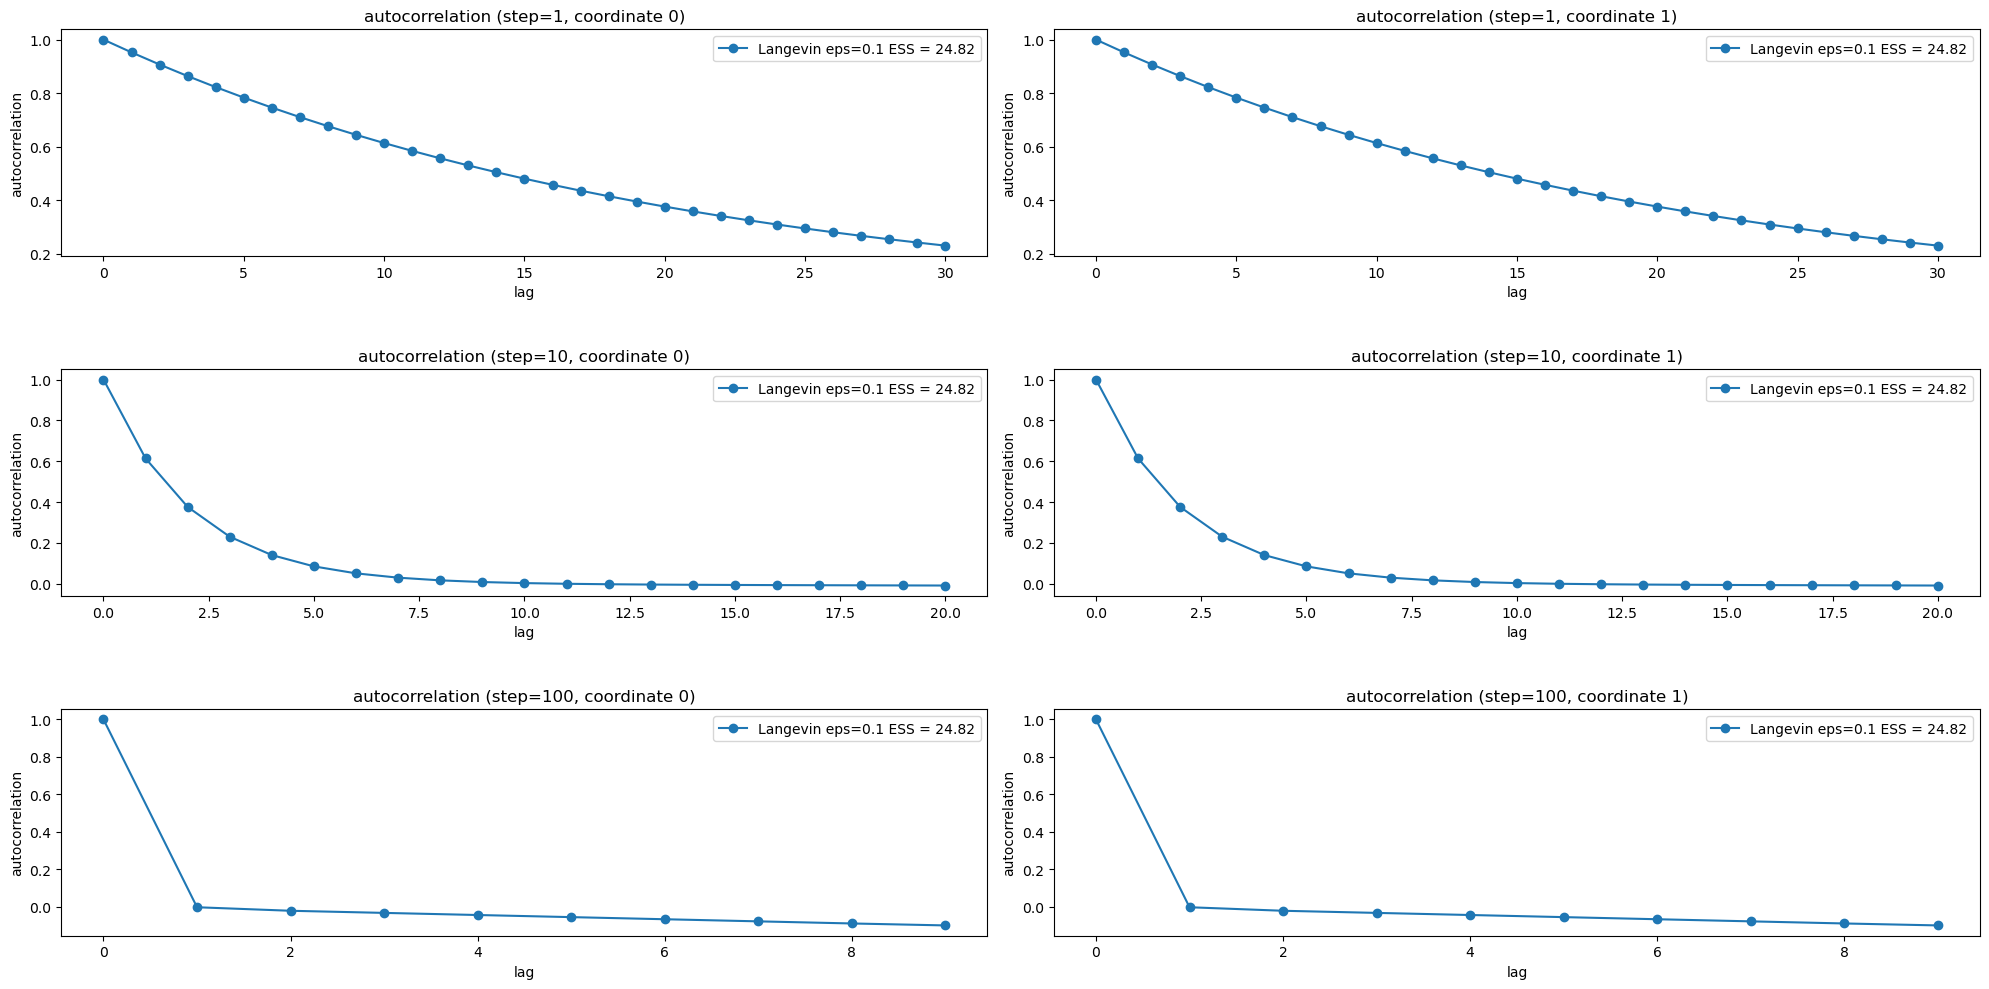

In [77]:
proposals = [
        Langevin(0.1, d=standard_normal)
]

autocorr_experiment_lanj(
    distribution=langevin,
    proposals=proposals,
    steps=[1, 10, 100],
    options = dict(
        initial_point=torch.tensor([0., 0.]),
        n_samples=1000,
        n_parallel=10
    )
);

In [69]:
class RandomWalk(Proposal):
    """Proposal of the form q(x' | x) = N(x' | x, \sigma^2)"""

    def __init__(self, sigma):
        self.sigma = sigma
        self.d = dist.Normal(loc=0., scale=sigma)

    def sample(self, x):
        return x + self.d.sample(sample_shape=x.shape)

    def log_density(self, x, x_prime):
        return self.d.log_prob(x_prime - x).sum()

    def __str__(self):
        return f"Random walk sigma={self.sigma}"

### Metropolis

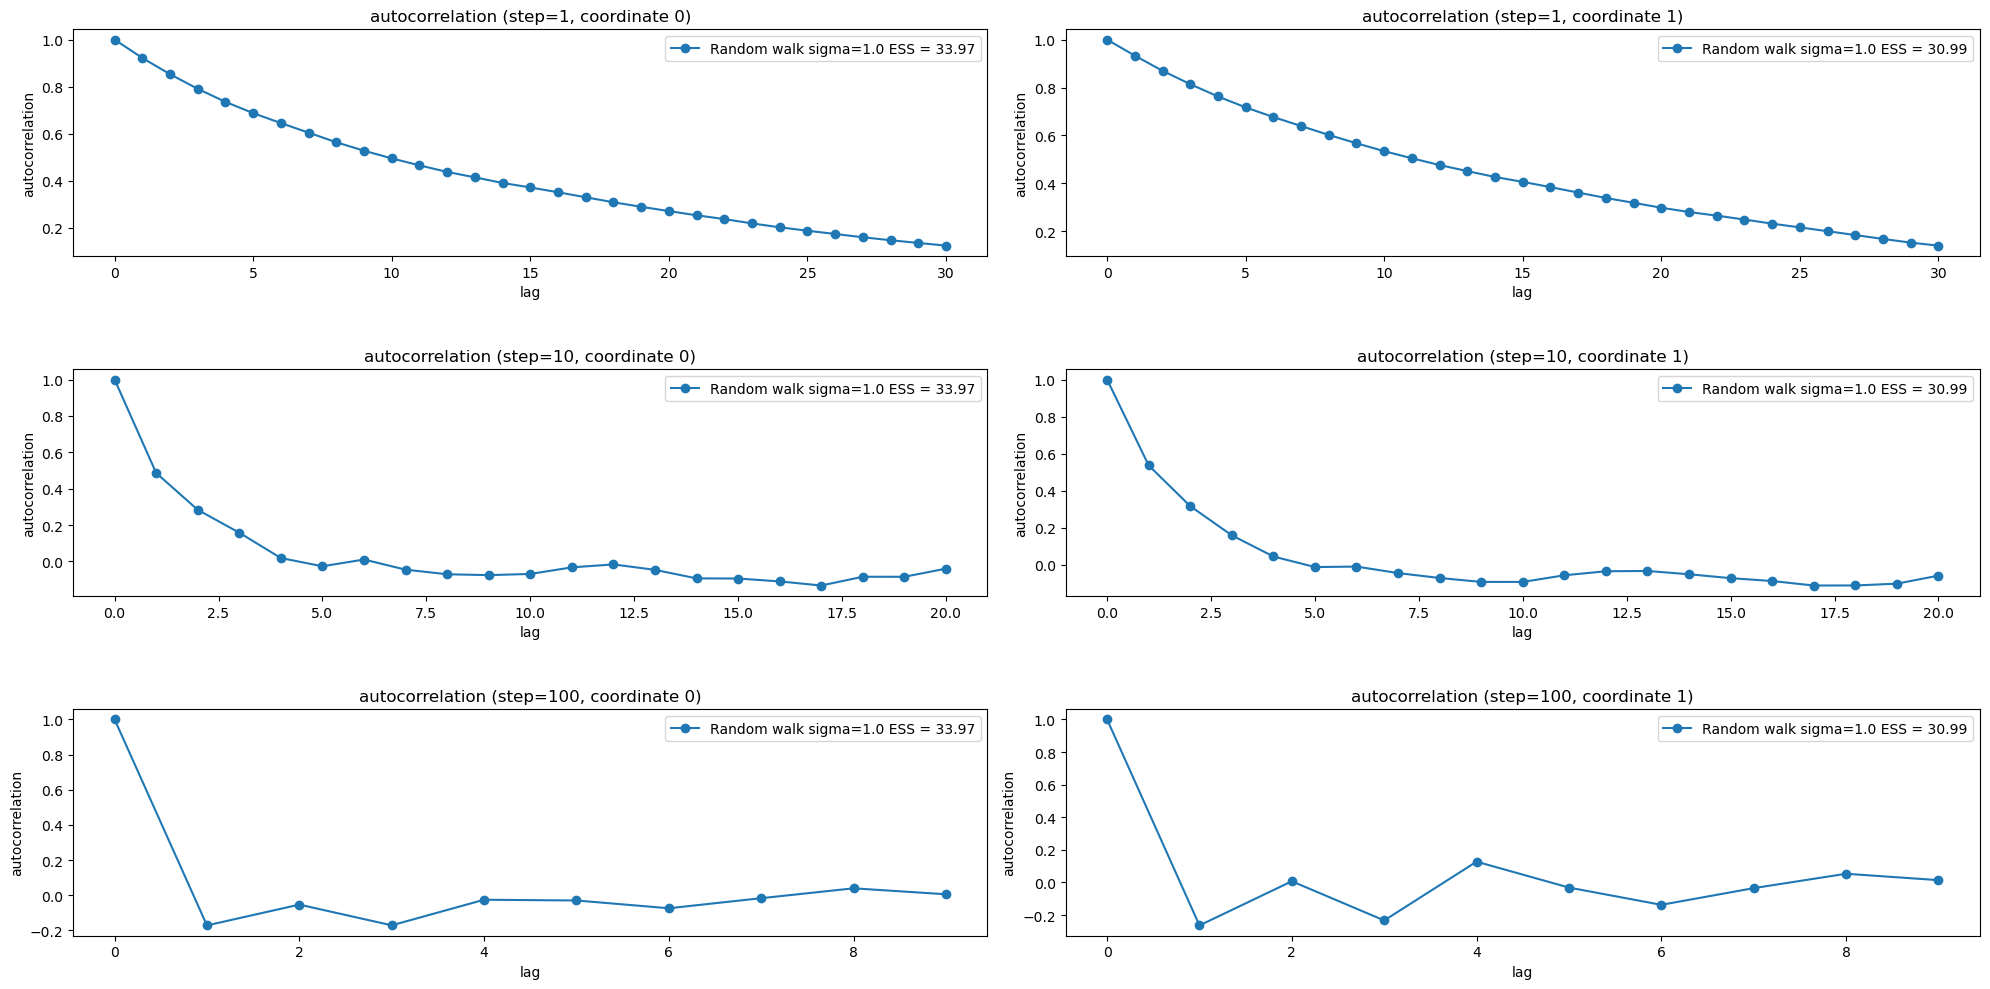

In [76]:
proposals = [
        RandomWalk(1.0),
]

autocorr_experiment(
    distribution=langevin,
    proposals=proposals,
    steps=[1, 10, 100],
    options = dict(
        initial_point=torch.tensor([0., 0.]),
        n_samples=1000,
        n_parallel=10
    )
);